# Modelos usando el algoritmo de arboles de decisión

### Importación de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from matplotlib import pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV

import informe
import preprocessing

from sklearn.metrics import classification_report

from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

### Llamado a funciones de preprocesamiento

#### Conversión de variables
- Hay que convertir todos los features categóricos a númericos. Para variables categóricas se usarán Dummy Variables y para ordinales OrdinalEncoder.

In [3]:
df = preprocessing.remove_irrelevant_features(df)
df = preprocessing.missings_treatment(df)
df = preprocessing.one_hot_encodding(df)
X = df.drop('tiene_alto_valor_adquisitivo', axis='columns')

# Se separa el dataset en entrenamiento y holdout
y = df.tiene_alto_valor_adquisitivo
X_train, X_holdout, y_train, y_holdout = preprocessing.dataset_split(X, y)

### Modelos

#### Modelo 1
- Se usan todos los features para entrenar el modelo

In [4]:
modelo1 = tree.DecisionTreeClassifier(random_state=117)
params = {'max_depth': np.arange(1, 9), 'min_samples_leaf': np.arange(1, 16)}

metricas = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

rscv = RandomizedSearchCV(
    modelo1, params, n_iter=60, scoring=metricas, n_jobs=-1, cv=5, return_train_score=True, refit = 'roc_auc'
).fit(X_train, y_train)

informe.imprimir_metricas(rscv, X_train, y_train, nombre = "modelo 1")

modelo1 = rscv.best_estimator_

Resultados modelo 1
    Mejores hiperparámetros: {'min_samples_leaf': 15, 'max_depth': 8}
    Métrica AUC ROC: 0.90
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     17303
           1       0.80      0.55      0.65      5489

    accuracy                           0.86     22792
   macro avg       0.84      0.75      0.78     22792
weighted avg       0.85      0.86      0.85     22792



#### Modelo 2
- se seleccionan los features mas relevantes haciendo embedding, el resto se descartan 

In [5]:
X_train_c = X_train.copy()

features_relevantes = preprocessing.embedded(X_train_c, y_train, min_importance=0.05).columns
X_train_reducido = X_train[features_relevantes]
X_holdout_reducido = X_holdout[features_relevantes]

In [6]:
modelo2 = tree.DecisionTreeClassifier(random_state=117)
params = {'max_depth': np.arange(2, 9), 'min_samples_leaf': np.arange(2, 16)}

metricas = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

rscv = RandomizedSearchCV(
    modelo2, params, n_iter=60, scoring=metricas, n_jobs=-1, cv=5, return_train_score=True, refit = 'roc_auc'
).fit(X_train_reducido, y_train)

informe.imprimir_metricas(rscv, X_train_reducido, y_train, nombre = "modelo 2")

modelo2 = rscv.best_estimator_

Resultados modelo 2
    Mejores hiperparámetros: {'min_samples_leaf': 3, 'max_depth': 8}
    Métrica AUC ROC: 0.90
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     17303
           1       0.81      0.54      0.65      5489

    accuracy                           0.86     22792
   macro avg       0.84      0.75      0.78     22792
weighted avg       0.85      0.86      0.85     22792



#### Modelo 3
- Con los features mas relevantes se arma un ensamble usando la estrategia bagging con la cual se construyen multiples estimadores para definir las predicciones

In [7]:
modelo3 = BaggingClassifier(base_estimator=DecisionTreeClassifier())

params = {'base_estimator__max_depth': np.arange(2, 9), 'base_estimator__min_samples_leaf': np.arange(2, 16)}
metricas = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

rscv = RandomizedSearchCV(
    modelo3, params, n_iter=60, scoring=metricas, n_jobs=-1, cv=5, return_train_score=True, refit = 'roc_auc'
).fit(X_train_reducido, y_train)

informe.imprimir_metricas(rscv, X_train_reducido, y_train, nombre = "modelo 3")

modelo3 = rscv.best_estimator_

Resultados modelo 3
    Mejores hiperparámetros: {'base_estimator__min_samples_leaf': 7, 'base_estimator__max_depth': 8}
    Métrica AUC ROC: 0.90
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     17303
           1       0.80      0.55      0.65      5489

    accuracy                           0.86     22792
   macro avg       0.84      0.75      0.78     22792
weighted avg       0.85      0.86      0.85     22792



#### Modelo 4
- Análogo al modelo 3, pero usando un ensamble de tipo random forest, el cual es más adecuada para ensamble de arboles

In [8]:
modelo4 = RandomForestClassifier(max_depth=20)

params = {'max_depth': np.arange(2, 9), 'min_samples_leaf': np.arange(2, 16)}
metricas = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

rscv = RandomizedSearchCV(
    modelo4, params, n_iter=60, scoring=metricas, n_jobs=-1, cv=5, return_train_score=True, refit = 'roc_auc'
).fit(X_train_reducido, y_train)

informe.imprimir_metricas(rscv, X_train_reducido, y_train, nombre = "modelo 4")

modelo4 = rscv.best_estimator_

Resultados modelo 4
    Mejores hiperparámetros: {'min_samples_leaf': 3, 'max_depth': 8}
    Métrica AUC ROC: 0.91
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     17303
           1       0.81      0.55      0.65      5489

    accuracy                           0.86     22792
   macro avg       0.84      0.75      0.78     22792
weighted avg       0.85      0.86      0.85     22792



### Conclusión
      En base a la metrica AUC-ROC, se ve que los 4 modelos performan practicamente igual. Sin mayor justificación se elige el modelo 4, ya que en general los ensamblados brindan buenos resultados y el random forest esta pensado justamente para arboles.
      
### Informe del modelo 4 usando los datos del test_holdout

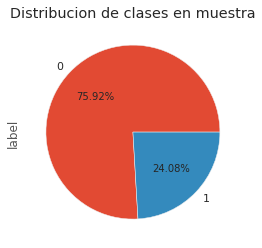

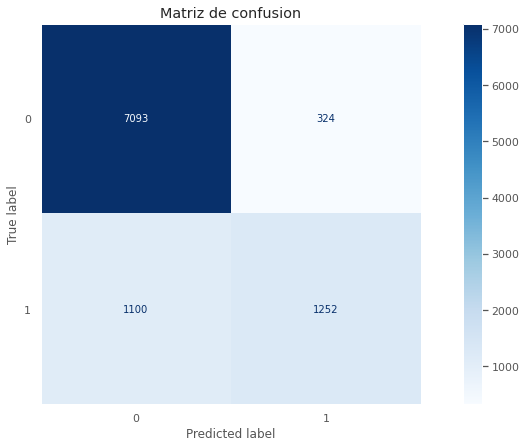

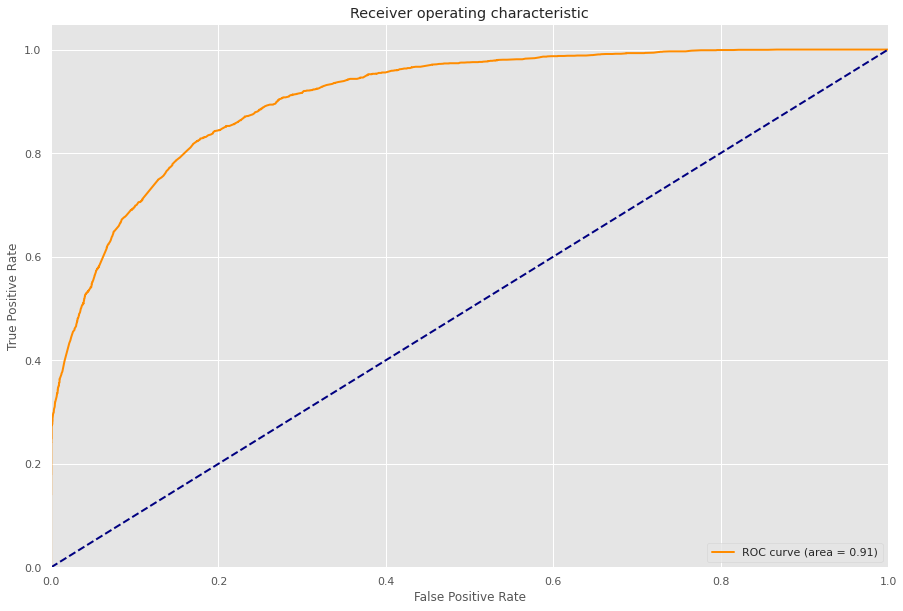

Métricas:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7417
           1       0.79      0.53      0.64      2352

    accuracy                           0.85      9769
   macro avg       0.83      0.74      0.77      9769
weighted avg       0.85      0.85      0.84      9769



In [9]:
informe.imprimir_informe(modelo4, X_holdout_reducido, y_holdout)

### Conclusiones de las métricas observadas de los datos de hold_out

- accuracy:

        El modelo clasifica los datos de forma correcta en aproximadamente un 85%, viendo la distribucion de clases de la muestra se observa que el 0 es la clase mayoritaria con una proporción de aproximadamente 76%. Por lo tanto el modelo es mejor predictor que devolver siempre cero.
    
    
- precisión:

        La fracción de predicciones de 0's que realmente eran 0's fue de aproximadamente 87% y la fracción de predicciones de 1's que realmente eran 1's fue del 79% 


- recall:

        Los 0's reales detectados fueron aproximadamente del 96%, y los 1's reales detectados fueron del 53%. Viendo este resultado en conjunto con la precisión, se entiende que el modelo es bueno prediciendo los 0's pero prediciendo los 1's tiene un comportamiento aleatorio, ya que aproximadamente la mitad de las veces lo detecta y la otra mitad no 


- f1 score:
   
       La calidad del modelo es de 84% en terminos del recall y la precision asi como el balance entre ambas.
       
       
- matriz de confusion:

        Se puede ver que las predicciones mayoritarias caen en la diagonal principal, lo cual es una buena caracteristica de una matriz de confusión. Sin embargo para los 1's, las dos columnas estan demasiado balanceadas, lo cual ya se sabia ya que en el resultado de recall para los 1's era aproximadamente del 50%.
        Aproximadamente el 85% de las instancias se encuentran en la diagonal principal, (lo cual ya sabiamos por el accuracy del 85%)
        
        
- UAC ROC:

        Esta métrica indica que el modelo es bueno distinguiendo clases en un 91%. Este valor será utilizado para decidir sobre la elección de este modelo.


# Final test

In [12]:
df_test = informe.get_df_test()

#preprocesamiento
df_test = preprocessing.remove_irrelevant_features(df_test)
df_test = preprocessing.missings_treatment(df_test)
df_test = preprocessing.one_hot_encodding(df_test)
df_test = df_test[features_relevantes]

y_pred = modelo4.predict(df_test)
informe.save_pred(y_pred, 'arbol')